## Classifier Performance: Constructing a QSO catalogue
#### Plot to show performance when constructing a catalogue
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of constructing a QSO catalogue. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
import numpy as np
import copy
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, utils, variables

In [2]:
figsize = (12,8)
fontsize = 18

temp_output_loc = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/'

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q.fits'
data['RR'] = utils.load_rr_data(f_rr)

## Load the new RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_test.fits'
data['RRnew'] = utils.load_rr_data(f_rr)

## Load the RRngp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngp.fits'
data['RRngp'] = utils.load_rr_data(f_rr)

## Load BOSS pipeline data.
f_pipe = temp_output_loc+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
#f_pipe = temp_output_loc+'/dr14pipe_results/dr14pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_pipe)

## Load the QN single exposure data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_snr/qn_modelsingexp_testsingexp.fits'
data['QNsingexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_training_set_size/qn_10pc.fits'
data['QN'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the SQ data.
f_sq = temp_output_loc+'/results/sq_results/sq_sdr12q.fits'
data['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq)
data_table[:5]

INFO: 294024 common spectra


OBJ_ID,SPEC_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_RRnew,Z_RRngp,Z_PIPE,Z_QNsingexp,Z_QN,Z_SQ,CLASS_RR,CLASS_RRnew,CLASS_RRngp,CLASS_PIPE,CLASS_QNsingexp,CLASS_QN,CLASS_SQ,ISQSO_RR,ISQSO_RRnew,ISQSO_RRngp,ISQSO_PIPE,ISQSO_QNsingexp,ISQSO_QN,ISQSO_SQ,C_QNsingexp [6],C_QN [6],P_SQ,ZWARN_RR,ZWARN_RRnew,ZWARN_RRngp,ZWARN_PIPE
int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8,str8,str8,str8,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,int64,int64,int64,int64
87897905,3586551810016,2,2.242,QSO,True,2.238,2.237,2.236,2.242,2.242,2.244,2.233,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,1.000 .. 0.000,1.000 .. 0.000,0.958,0,0,0,0
87896919,3586551810032,2,0.000,STAR,False,0.001,0.689,0.751,-0.003,0.647,2.366,0.647,STAR,GALAXY,GALAXY,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,0.000 .. 0.000,0.000 .. 0.000,0.151,0,4,4,4
87897024,3586551810036,2,0.000,STAR,False,-0.000,-0.000,-0.000,-0.000,2.093,2.108,2.303,STAR,GALAXY,GALAXY,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,0.000 .. 0.000,0.000 .. 0.000,0.059,0,0,0,0
94817272,3586551810038,2,2.196,QSO,True,2.170,0.191,0.191,2.166,2.181,2.204,2.179,QSO,GALAXY,GALAXY,QSO,QSO,QSO,QSO,True,False,False,True,True,True,True,1.000 .. 0.000,0.541 .. 0.000,0.780,0,0,0,64
87897405,3586551810040,2,0.000,STAR,False,-0.000,-0.000,-0.000,-0.000,1.687,2.112,-1.000,STAR,STAR,STAR,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,0.000 .. 0.000,0.000 .. 0.000,-1.000,0,0,0,0


In [7]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

287996

### Evaluate performance of classifiers at constructing a QSO catalogue.
xxx

In [8]:
data_table_archive = copy.deepcopy(data_table)

In [9]:
# Define some parameters
dv_max = 6000. #km/s
show_correctwrongzbin = False
zbins = [(0.9,2.1),(2.1,None)]
desi_nqso=[1.3*10**6,0.8*10**6]

In [10]:
## Define the strategies
stratdef = {}


## Single classifiers.
# QN definitions.
cth = 0.3
n_detect = 1
w_qn = ((data_table['C_QN']>cth).sum(axis=1)>=n_detect)
z_qn = copy.deepcopy(data_table['Z_QN'])
stratdef['QN'] = {'w': w_qn, 'z': z_qn}

# RR definitions.
zwarn = data_table['ZWARN_RR']>0
w_rr = copy.deepcopy(data_table['ISQSO_RR'])
w_rr[zwarn] = False
z_rr = copy.deepcopy(data_table['Z_RR'])
stratdef['RR'] = {'w': w_rr, 'z': z_rr}

# RR incl. zwarn definitions.
z_rr = copy.deepcopy(data_table['Z_RR'])
w_rr = copy.deepcopy(data_table['ISQSO_RR'])
stratdef['RRzwarn'] = {'w': w_rr, 'z': z_rr}

# PIPE definitions.
w_pipe = copy.deepcopy(data_table['ISQSO_PIPE'])
z_pipe = copy.deepcopy(data_table['Z_PIPE'])
stratdef['PIPE'] = {'w': w_pipe, 'z': z_pipe}

# SQ definitions.
pmin = 0.32
w_sq = data_table['P_SQ']>pmin
z_sq = copy.deepcopy(data_table['Z_SQ'])
stratdef['SQ'] = {'w': w_sq, 'z': z_sq}

# QN 2line definitions.
cth = 0.3
n_detect = 2
w_qn2line = ((data_table['C_QN']>cth).sum(axis=1)>=n_detect)
z_qn2line = copy.deepcopy(data_table['Z_QN'])
stratdef['QN2line'] = {'w': w_qn2line, 'z': z_qn2line}

# RRnew definitions.
zwarn = data_table['ZWARN_RRnew']>0
z_rr = copy.deepcopy(data_table['Z_RRnew'])
w_rr = copy.deepcopy(data_table['ISQSO_RRnew'])
w_rr[zwarn] = False
stratdef['RRnew'] = {'w': w_rr, 'z': z_rr}

# RRngp definitions.
zwarn = data_table['ZWARN_RRngp']>0
w_rr = copy.deepcopy(data_table['ISQSO_RRngp'])
w_rr[zwarn] = False
z_rr = copy.deepcopy(data_table['Z_RRngp'])
stratdef['RRngp'] = {'w': w_rr, 'z': z_rr}


## Simple & | combinations of classifiers.
# QN|RR definitions.
w_or = (stratdef['QN']['w'] | stratdef['RR']['w'])
z_or = copy.deepcopy(data_table['Z_RR'])
z_or[stratdef['QN']['w']] = copy.deepcopy(data_table['Z_QN'])[stratdef['QN']['w']]
stratdef['QN|RR'] = {'w': w_or, 'z': z_or}

# QN&RR definitions
dv_qnrr = (300000.*abs(data_table['Z_QN'] - data_table['Z_RR'])/(1 + data_table['Z_VI']))
w_and = ((stratdef['QN']['w'] & stratdef['RR']['w']) & (dv_qnrr<dv_max))
z_and = copy.deepcopy(data_table['Z_RR'])
z_and[stratdef['QN']['w']] = copy.deepcopy(data_table['Z_QN'])[stratdef['QN']['w']]
stratdef['QN&RR'] = {'w': w_and, 'z': z_and}

# QN|PIPE definitions.
w_or = (stratdef['QN']['w'] | stratdef['PIPE']['w'])
z_or = copy.deepcopy(data_table['Z_PIPE'])
z_or[stratdef['QN']['w']] = copy.deepcopy(data_table['Z_QN'])[stratdef['QN']['w']]
stratdef['QN|PIPE'] = {'w': w_or, 'z': z_or}

# QN&PIPE definitions
dv_qnpipe = (300000.*abs(data_table['Z_QN'] - data_table['Z_PIPE'])/(1 + data_table['Z_VI']))
w_and = ((stratdef['QN']['w'] & stratdef['PIPE']['w']) & (dv_qnpipe<dv_max))
z_and = copy.deepcopy(data_table['Z_PIPE'])
z_and[stratdef['QN']['w']] = copy.deepcopy(data_table['Z_QN'])[stratdef['QN']['w']]
stratdef['QN&PIPE'] = {'w': w_and, 'z': z_and}

# QN|RR zRR definitions.
w_or = (stratdef['QN']['w'] | stratdef['RR']['w'])
z_or = copy.deepcopy(data_table['Z_RR'])
qn_notrr = stratdef['QN']['w'] & (~stratdef['RR']['w'])
z_or[qn_notrr] = copy.deepcopy(data_table['Z_QN'])[qn_notrr]
stratdef['| zRR'] = {'w': w_or,'z': z_or}

# QN&RR zRR definitions.
dv_qnrr = (300000.*abs(data_table['Z_QN'] - data_table['Z_RR'])/(1 + data_table['Z_VI']))
w_and = ((stratdef['QN']['w'] & stratdef['RR']['w']) & (dv_qnrr<dv_max))
z_and = copy.deepcopy(data_table['Z_RR'])
stratdef['& zRR'] = {'w': w_and,'z': z_and}


## Strategies involving VI.
# RR+VI definitions
zwarn = data_table['ZWARN_RR']>0
vi = np.zeros(len(data_table),dtype=bool)
for b in [1,2,3,4,5,6,10]:
    vi |= (data_table['ZWARN_RR']&(2**b))>0
w_rrplusvi = np.zeros(len(data_table),dtype=bool)
w_rrplusvi[~vi] = copy.deepcopy(data_table['ISQSO_RR'][~vi])
w_rrplusvi[vi] = copy.deepcopy(data_table['ISQSO_VI'][vi])
z_rrplusvi = np.zeros(len(data_table))
z_rrplusvi[~vi] = copy.deepcopy(data_table['Z_RR'][~vi])
z_rrplusvi[vi] = copy.deepcopy(data_table['Z_VI'][zwarn])
print('RR+VI asks for {} VIs'.format(vi.sum()))
stratdef['RR+VI'] = {'w': w_rrplusvi, 'z': z_rrplusvi,}

# QN+VI definitions.
cth_hi = 0.9
cth_lo = 0.1
n_detect = 1
qn_defqso = ((data_table['C_QN']>cth_hi).sum(axis=1)>=n_detect)
qn_defnonqso = ((data_table['C_QN']>cth_lo).sum(axis=1)==0) #(data_table['CMAX_QN']<cth_lo) 
qn_def = qn_defqso | qn_defnonqso
vi = ~qn_def
w_qnplusvi = np.zeros(len(data_table),dtype=bool)
w_qnplusvi[qn_defqso] = np.ones(len(data_table),dtype=bool)[qn_defqso]
w_qnplusvi[vi] = copy.deepcopy(data_table['ISQSO_VI'][vi])
z_qnplusvi = np.zeros(len(data_table))
z_qnplusvi[qn_def] = copy.deepcopy(data_table['Z_QN'][qn_def])
z_qnplusvi[vi] = copy.deepcopy(data_table['Z_VI'][vi])
print('QN+VI asks for {} VIs'.format(vi.sum()))
stratdef['QN+VI'] = {'w': w_qnplusvi, 'z': z_qnplusvi}

# QN&RR+VI definition 1.
# Classifies as QSO when QN has c>cth or if RR classifies as QSO without zwarn.
# Asks for VI when if one classifier says QSO but the other doesn't, or if the redshifts disagree.
cth = 0.3
n_detect = 1
isqso_qn = ((data_table['C_QN']>cth).sum(axis=1)>=n_detect)
isqso_rr = stratdef['RR']['w']
dv_rr_qn = (300000.*abs(data_table['Z_QN'] - data_table['Z_RR'])/(1 + data_table['Z_VI']))
vi = ((isqso_qn|isqso_rr) & (~(isqso_qn&isqso_rr))) | ((isqso_qn & isqso_rr) & (dv_rr_qn>=dv_max))
w_rrplusqnplusvi = np.zeros(len(data_table),dtype=bool)
w_rrplusqnplusvi[isqso_qn&isqso_rr] = np.ones(len(data_table),dtype=bool)[isqso_qn&isqso_rr]
w_rrplusqnplusvi[vi] = copy.deepcopy(data_table['ISQSO_VI'])[vi]
z_rrplusqnplusvi = copy.deepcopy(data_table['Z_RR'])
z_rrplusqnplusvi[isqso_qn] = copy.deepcopy(data_table['Z_QN'])[isqso_qn]
z_rrplusqnplusvi[vi] = copy.deepcopy(data_table['Z_VI'])[vi]
print('QN&RR+VI asks for {} VIs ({:1.2%})'.format(vi.sum(),vi.sum()/len(data_table)))
stratdef['QN&RR+VI'] = {'w': w_rrplusqnplusvi, 'z': z_rrplusqnplusvi, 'label': 'QN&RR\n+VI'}

# QN&RR+VI definitions 2.
# Classifies as QSO when QN has c>cth_hi or if RR classifies as QSO without zwarn.
# Asks for VI if QN says c>cth_hi but RR has a zwarn.
# Also if RR says QSO without zwarn, and QN says cth_lo<c<cth_hi.
# Rejects if either QN says c<cth_lo or 
zwarn = data_table['ZWARN_RR']>0
isqso_rr = copy.deepcopy(data_table['ISQSO_RR'])
rr_defqso = (isqso_rr&(~zwarn))
rr_defnonqso = ((~isqso_rr)&(~zwarn))
cth_hi = 0.9
cth_lo = 0.1
n_detect = 1
qn_defqso = ((data_table['C_QN']>cth).sum(axis=1)>=n_detect)
qn_defnonqso = ((data_table['C_QN']>cth_lo).sum(axis=1)==0) #(data_table['CMAX_QN']<cth_lo)
qn_def = qn_defqso | qn_defnonqso
w = np.zeros(len(data_table),dtype=bool)
w[qn_defqso&rr_defqso] = np.ones(len(data_table),dtype=bool)[qn_defqso&rr_defqso]
vi = (qn_defqso&zwarn) | ((~qn_def)&rr_defqso)
w[vi] = copy.deepcopy(data_table['ISQSO_VI'])[vi]
z = copy.deepcopy(data_table['Z_QN'])
z[vi] = copy.deepcopy(data_table['Z_VI'])[vi]
print('QN&RR+VI adv. asks for {} VIs ({:1.2%})'.format(vi.sum(),vi.sum()/len(data_table)))
stratdef['QN&RR+VI adv.'] = {'w': w, 'z': z, 'label': 'QN&RR\n+VI adv.'}


RR+VI asks for 12438 VIs
QN+VI asks for 1728 VIs
QN&RR+VI asks for 9259 VIs (3.21%)
QN&RR+VI adv. asks for 2522 VIs (0.88%)


/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: divide by zero encountered in true_divide


In [11]:
zwarn_rr = data_table['ZWARN_RR']>0
zwarn_rrnew = data_table['ZWARN_RRnew']>0
zwarn_rrngp = data_table['ZWARN_RRngp']>0

print('RR',zwarn_rr.sum())
print('RRnew',zwarn_rrnew.sum())
print('RRngp',zwarn_rrngp.sum())

RR 12438
RRnew 18968
RRngp 19761


In [12]:
# Check that we haven't accidentally overwritten any data.
assert (data_table==data_table_archive).all()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


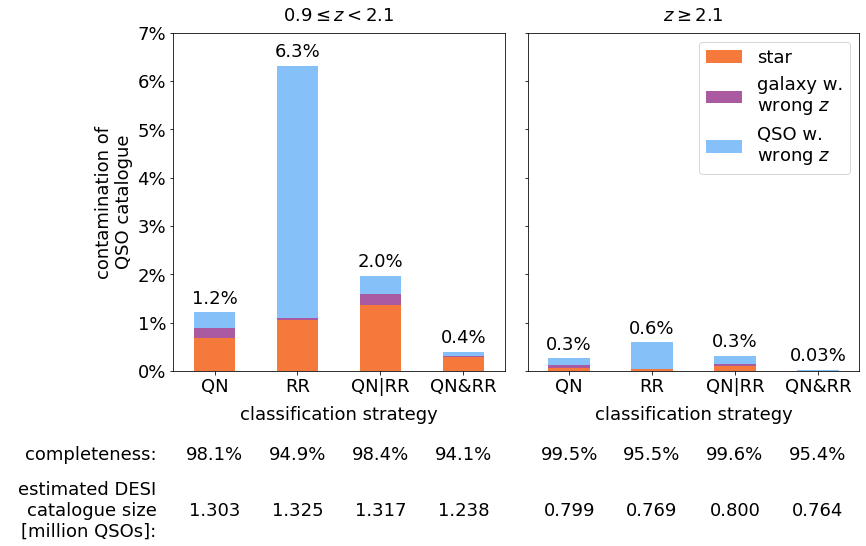

In [13]:
## Plot comparing QN, RR and simple combinations.
plot_strategies = ['QN','RR','QN|RR','QN&RR']
filename = '../plots/classifier_performance_constructing_a_catalogue.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


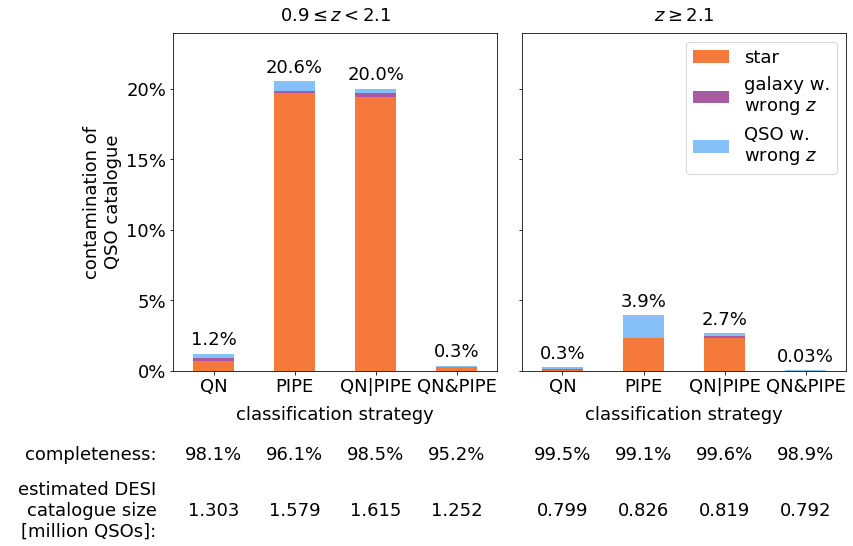

In [14]:
## As above but swapping redrock for DR12 pipeline
plot_strategies = ['QN','PIPE','QN|PIPE','QN&PIPE']
filename = '../plots/classifier_performance_constructing_a_catalogue_dr12pipe.pdf'
ymax = 0.24

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


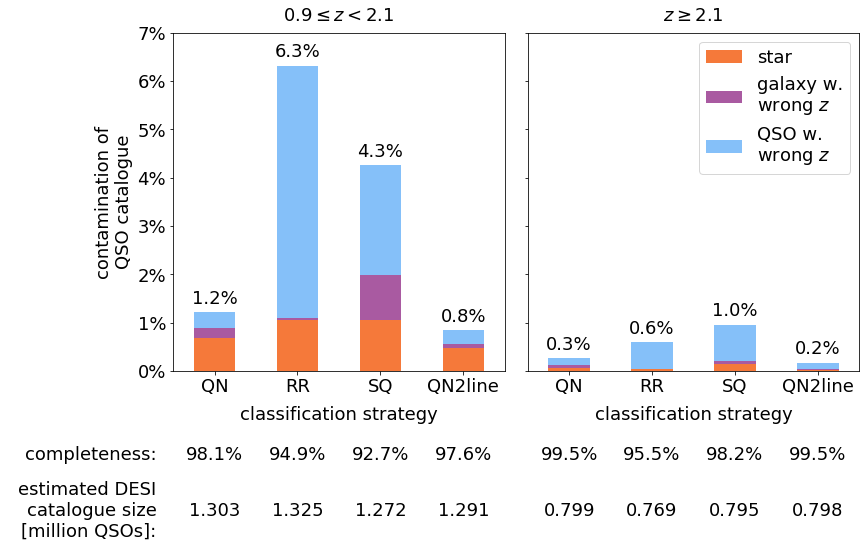

In [15]:
## Plot to compare different classifiers
plot_strategies = ['QN','RR','SQ','QN2line']
filename = '../plots/classifier_performance_constructing_a_catalogue_altstrat.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


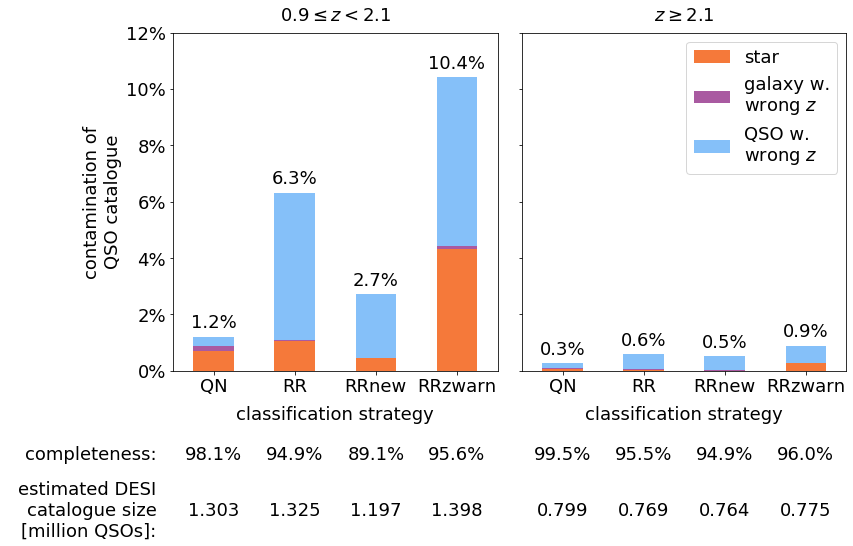

In [16]:
## Plot to show different redrock options.
plot_strategies = ['QN','RR','RRnew','RRzwarn']
filename = '../plots/classifier_performance_constructing_a_catalogue_rrnew.pdf'
ymax = 0.12

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


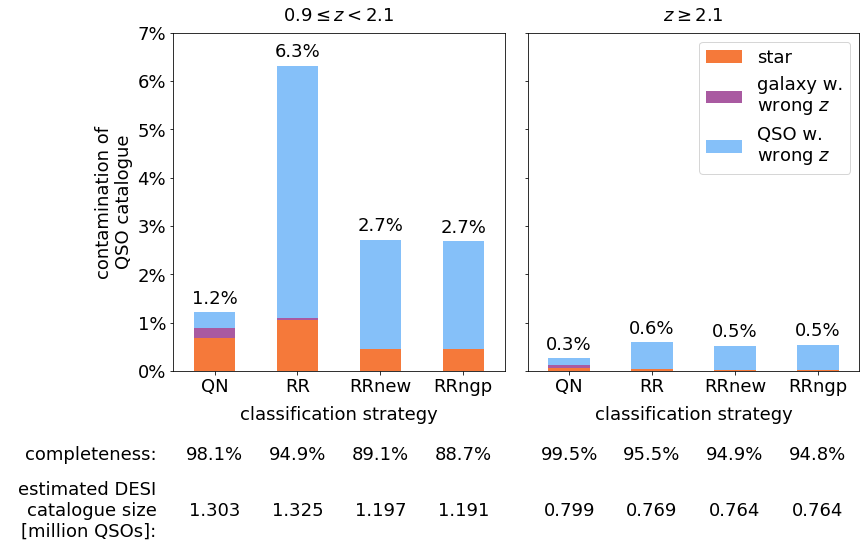

In [17]:
## Plot to show different redrock spCFrame interpolation methods.
plot_strategies = ['QN','RR','RRnew','RRngp']
filename = '../plots/classifier_performance_constructing_a_catalogue_rrtest.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


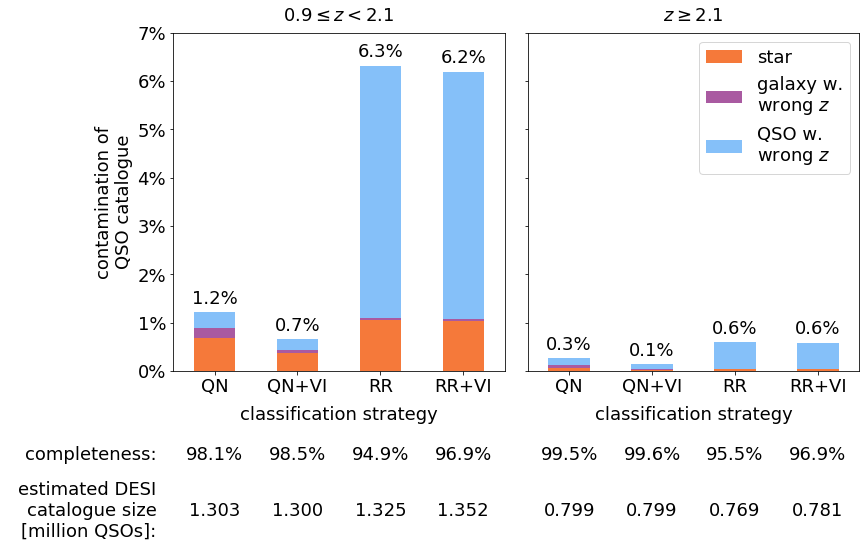

In [18]:
## Plot to test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN','QN+VI','RR','RR+VI']
filename = '../plots/classifier_performance_constructing_a_catalogue_plusvi.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


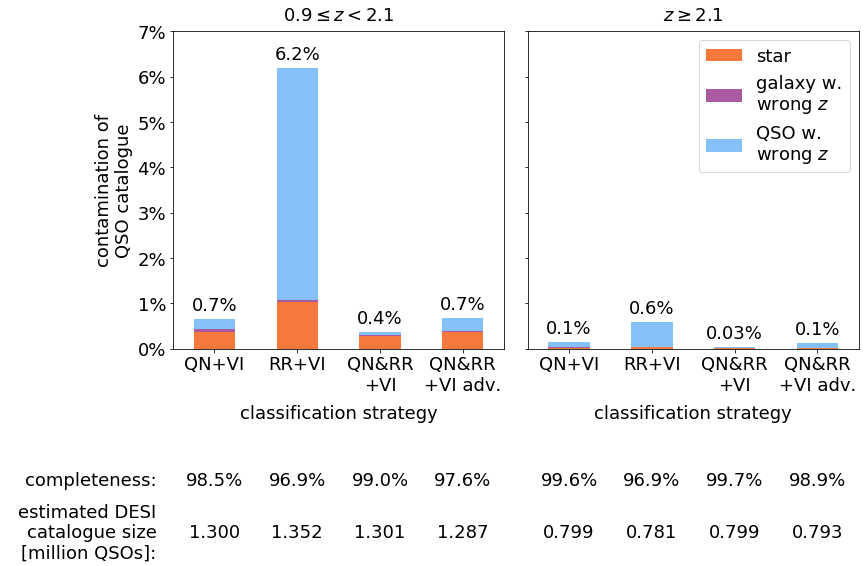

In [19]:
## Plot to further test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN+VI','RR+VI','QN&RR+VI','QN&RR+VI adv.']
filename = '../plots/classifier_performance_constructing_a_catalogue_complex.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


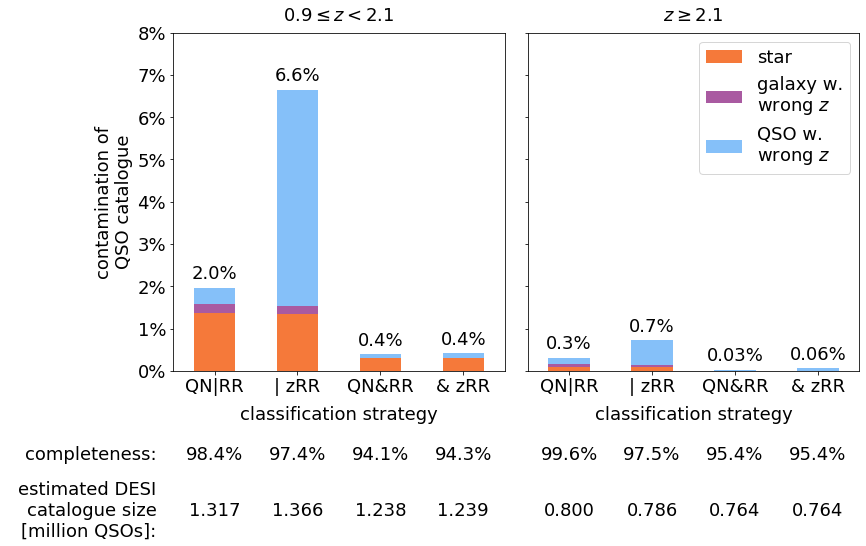

In [20]:
## Compare choice of redshift in simple combination strategies.
plot_strategies = ['QN|RR','| zRR','QN&RR','& zRR']
filename = '../plots/classifier_performance_constructing_a_catalogue_zrr.pdf'
ymax = 0.08

# Make the plot.
strategies = {s:stratdef[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()